<a href="https://colab.research.google.com/github/martynakol/UM-w-finansach/blob/main/Kopia_notatnika_FINAL_case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [666]:
# !pip install surprise

In [667]:
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from surprise.model_selection import train_test_split

In [668]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

# Przegląd danych

# 1.

In [669]:
# Number of movies for children
children_movies_count = movies[movies['genres'].str.contains('Children')].shape[0]
children_movies_count


664

# 2.

In [670]:
# Extract movies released in 1995
movies_1995 = movies[movies['title'].str.contains('\(1995\)')]

# Merge with ratings to get ratings for these movies
ratings_1995 = ratings[ratings['movieId'].isin(movies_1995['movieId'])]

# Distribution of ratings
rating_distribution_1995 = ratings_1995['rating'].value_counts().sort_index()
rating_distribution_1995



rating
0.5      50
1.0     254
1.5      75
2.0     522
2.5     244
3.0    1701
3.5     467
4.0    1625
4.5     308
5.0     898
Name: count, dtype: int64

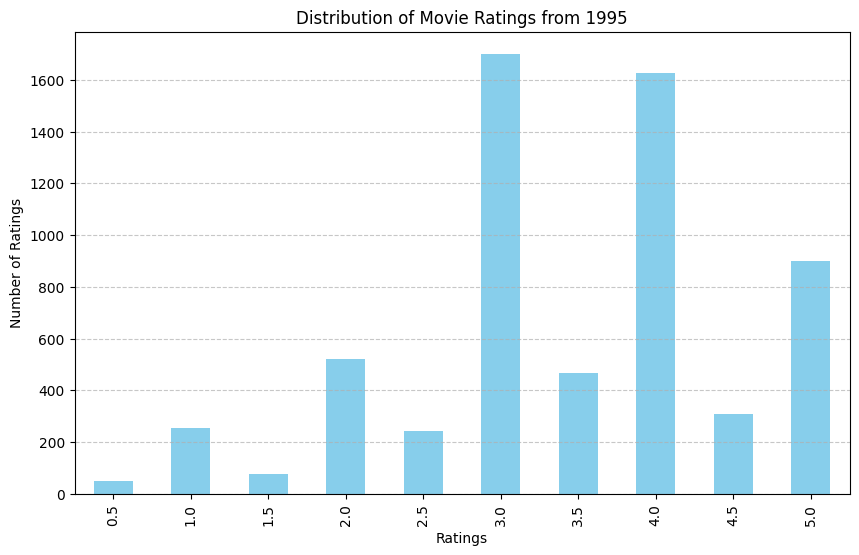

In [671]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
rating_distribution_1995.plot(kind='bar', color='skyblue')
plt.title('Distribution of Movie Ratings from 1995')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 3.

In [672]:
# Filter action movies
action_movies = movies[movies['genres'].str.contains('Action')]

# Merge action movies with ratings
action_movies_ratings = ratings[ratings['movieId'].isin(action_movies['movieId'])]

# Calculate the average rating for all action movies
average_rating_action = action_movies_ratings['rating'].mean()

# Group ratings by movie, calculate average and get the top 3 highest rated action movies
top_3_action_movies = action_movies_ratings.groupby('movieId').rating.mean().nlargest(3).index.tolist()

# Retrieve titles of the top 3 action movies
top_3_action_movies_details = movies[movies['movieId'].isin(top_3_action_movies)]

print(average_rating_action)

top_3_action_movies_details[['title', 'genres']]


3.447984331646809


,title,genres
666,Supercop 2 (Project S) (Chao ji ji hua) (1993),Action|Comedy|Crime|Thriller
1228,"Assignment, The (1997)",Action|Thriller
1647,Knock Off (1998),Action


# System rekomendacyjny

Standardowy kNN (k-Nearest Neighbors) - jest to algorytm oparty na podobieństwie, który wybiera k najbliższych sąsiadów obiektu i dokonuje predykcji na ich podstawie. W przypadku rekomendacji, predykcja (na przykład ocena filmu) jest średnią oceną z tych k sąsiadów.

kNN with Means - ten algorytm działa podobnie do standardowego kNN, ale wprowadza dodatkowy krok normalizacji. Dla każdego użytkownika obliczana jest średnia ocena, którą wydał, a następnie ta średnia jest wykorzystywana do skorygowania ocen przy obliczaniu predykcji. Dzięki temu algorytm może lepiej radzić sobie z różnicami w sposobie oceniania przez różnych użytkowników.

In [673]:
df = pd.merge(ratings, movies[['movieId', 'genres']], on = 'movieId', how = 'left')

df

,userId,movieId,rating,timestamp,genres
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Comedy|Romance
2,1,6,4.0,964982224,Action|Crime|Thriller
3,1,47,5.0,964983815,Mystery|Thriller
4,1,50,5.0,964982931,Crime|Mystery|Thriller
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Horror
100834,610,168252,5.0,1493846352,Action|Sci-Fi


In [674]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
mlb = MultiLabelBinarizer()

df['userId'] = user_encoder.fit_transform(df['userId'])
df['movieId'] = movie_encoder.fit_transform(df['movieId'])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres').str.split('|')), columns = mlb.classes_, index = df.index ))

In [675]:
df

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,4.0,964982703,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,2,4.0,964981247,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,5,4.0,964982224,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,43,5.0,964983815,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,46,5.0,964982931,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,609,9416,4.0,1493848402,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,609,9443,5.0,1493850091,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,609,9444,5.0,1494273047,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,609,9445,5.0,1493846352,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [676]:
df.drop(columns = "(no genres listed)", inplace = True)

In [677]:
from surprise import Dataset, Reader, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np


reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)


param_grid = {'k': range(3, 11)}
gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
gs_knn.fit(data)
print("Best k for RMSE:", gs_knn.best_params['rmse']['k'])


model_svd = SVD()
trainset = data.build_full_trainset()
model_svd.fit(trainset)
model_knn = KNNWithMeans(k=gs_knn.best_params['rmse']['k'])
model_knn.fit(trainset)


movie_titles = dict(zip(movies['movieId'], movies['title']))

def get_recommendations_knn(model, movie_title, movie_dict, n=10):
    movie_id = list(movie_dict.keys())[list(movie_dict.values()).index(movie_title)]


    try:
        inner_id = model.trainset.to_inner_iid(movie_id)
    except ValueError:
        print("Movie not found in the training set.")
        return


    neighbors = model.get_neighbors(inner_id, k=n)
    neighbor_ids = [model.trainset.to_raw_iid(inner_id) for inner_id in neighbors]


    print(f"Because you watched {movie_title}:")
    for neighbor_id in neighbor_ids:
        print(movie_dict.get(neighbor_id, "No title found"))

def get_similar_movies_svd(model, movie_title, movie_dict, n=10):
    movie_id = list(movie_dict.keys())[list(movie_dict.values()).index(movie_title)]


    try:
        inner_id = model.trainset.to_inner_iid(movie_id)
    except ValueError:
        print("Movie not found in the training set.")
        return


    similarities = []
    for other_inner_id in model.trainset.all_items():
        if other_inner_id != inner_id:
            vec1 = model.qi[inner_id]
            vec2 = model.qi[other_inner_id]
            sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            similarities.append((other_inner_id, sim))


    similarities.sort(key=lambda x: x[1], reverse=True)


    print(f"Because you watched {movie_title}:")
    for idx, (inner_id, _) in enumerate(similarities[:n]):
        movie_id = model.trainset.to_raw_iid(inner_id)
        print(movie_dict.get(movie_id, "No title found"))


get_recommendations_knn(model_knn, 'NeverEnding Story III, The (1994)', movie_titles, n=10)
get_similar_movies_svd(model_svd, 'NeverEnding Story III, The (1994)', movie_titles, n=10)

print("Cross-validation results for SVD:")
cross_validate(model_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Cross-validation results for KNNWithMeans:")
cross_validate(model_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

{'test_rmse': array([0.9052136 , 0.90642471, 0.90469685, 0.90818452, 0.90386445]),
 'test_mae': array([0.69802993, 0.69385915, 0.69235412, 0.69655954, 0.69351957]),
 'fit_time': (0.13098788261413574,
  0.14019560813903809,
  0.1903548240661621,
  0.14037489891052246,
  0.13751506805419922),
 'test_time': (0.9339029788970947,
  1.4652888774871826,
  0.9925758838653564,
  1.0946087837219238,
  0.9013717174530029)}